### "Numerical optimization and large scale linear algebra"

In [69]:
from scipy import sparse
import numpy as np
import pandas as pd
from numpy.linalg import norm
from scipy.stats import rankdata
import time
import os
import matplotlib.pyplot as plt

#### 1. Να βρεθεί το διάνυσμα π με την μέθοδο των δυνάμεων. α = 0.85, το κριτήριο τερματισμού τ = $10^{−8}$ και το διάνυσμα a έχει 1 αν αντιστοιχεί σε κόμβο που δεν έχει προς τα έξω συνδέσμους και 0 αλλού.

Based on "Deeper Inside PageRank" paper, we need to follow some specific steps to retrieve the page rank vector π. First, the probability square matrix P needs to be created, whose rows $\textbf{i}$ represent the nodes and the columns $\textbf{j}$ represent the outlinks of these nodes. The value in page $\textbf{i}$ to page $\textbf{j}$ represents the probability that page $\textbf{i}$ will move to page $\textbf{j}$ in one step. This probability is calculated by finding the number of outlinks that each node has and assign the same weighted probability in each outlink. Hence, the probabilities in each row will sum up to one. 

The paper mentions that matrix ̅P should be created which changes danglings nodes in P matrix to non-danglings and finally matrix ̿P, which turns zero values to (1/n) where n is the number of nodes (pages). However, due to storage issues in python the sparse matrix P will be used. 

Finally, the paper mentions that the PageRank vector can be viewed as an eigenvector problem and concludes that through the power method we can calculate π using only sparse matrix P. Therefore, through some iterations in power method we calculate π with the following equation:

$$\textbf{x}^{(k)T}=\alpha\textbf{x}^{(k−1)T}P+(\alpha\textbf{x}^{(k−1)T}\textbf{a}+(1−\alpha))\textbf{v}^T $$

where $\textbf{a}$ is a vector which takes the value 1 in danglings nodes and zero otherwise. $\textbf{α}$ is a given constant and $\textbf{v}^T$ is a vector with size $\textbf{n}$ which contains the value $\textbf{1/n}$. Lastly, the iterations stop when the 1-norm of  $\textbf{x}^{(k)T}-\textbf{x}^{(k−1)T}$ is smaller than the terminate criterion of $10^{−8}$.

Some of the advantages of this method are that in each iteration it only requires the storage of one vector and normally needs roughly 50 to 100 iterations.

In [70]:
#Import the file by reading each line (from the second line which includes nodes and outlinks)
path=r'Insert path.......................................................'
os.chdir(path)
file=open('out.web-BerkStan','r').readlines()[2:]

In [71]:
#Create two DataFrames which include nodes and outlinks
#Subtruct 1 from each node and outlink, because each matrix index starts from zero 
nodes=[]
outlink=[]
for i in range(len(file)):
    nodes.append(int(file[i].split()[0])-1)
    outlink.append(int(file[i].split()[1])-1)
    
nodes1=pd.DataFrame(nodes)
nodes1=nodes1.rename(columns={0:'node'})
outlink1=pd.DataFrame(outlink)
outlink1=outlink1.rename(columns={0:'outlink'})

In [72]:
#Create the weights that the sprarse matrix P will contain

#Calculate how many times each node appears in nodes1 DataFrame
counts1 =nodes1['node'].value_counts()

#Calculate the weight of each node
nodes1['weight'] = nodes1['node'].apply(lambda x: 1/counts1[x])

In [73]:
#Construct sparse matrix P as in pageranking.pdf
P1=sparse.csr_matrix((nodes1['weight'],(nodes1['node'],outlink1['outlink'])))

In [74]:
#Number of nodes
n1=P1.shape[0]

#Create a starting vector X
X0=np.array([1/n1]*n1)

#Create v vector as in pageranking.pdf
v=np.array([1/n1]*n1)

alpha1=0.85

#Terminate criterion of power method
t=10**(-8)

In [75]:
#Create fuction for vector a (dangling nodes take the value 1)
def a_function(n,p):
    a=[]
    for i in range(n):
        if p[i,:].count_nonzero()==0:
            a.append(1)
        else:
            a.append(0)    
    a=np.array(a)
    return a

In [76]:
#Create function for X vector through power method
def X_function(X0,p,t,alpha,a,v):   
    terminate=10**100
    iteration=0
    while terminate>t:
        X=alpha*sparse.csr_matrix.dot(X0.T,p)+(alpha*np.dot(X0.T,a)+(1-alpha))*v.T
        terminate=norm(X-X0,1)
        X0=X
        iteration=iteration+1
    return X,iteration

In [77]:
#Calculate vector a
a1=a_function(n1,P1)

In [78]:
#Calculate X vector with power method
start_time = time.time()
X1,iteration1=X_function(X0,P1,t,alpha1,a1,v)

#Calculate the time and number of iterations of power method
print("Power method needed",time.time()-start_time,"seconds and ", iteration1, "iterations")

Power method needed 2.110398054122925 seconds and  92 iterations


In [79]:
#Rank each node based on the X
rank1=rankdata(X1,method='ordinal')

#Sort the ranked nodes
sorted1=np.argsort(rank1)

### * Note 1:
#### The vector X which is calculated above is the vector π which is needed for this assignment

### ** Note 2:
#### Rankdata which is used above, ranks each node from worst to best, as it assigns the rank 1 to the node with the lowest value in vector π and the rank 685230 to the best node.
#### Sorted1 vector sorts the nodes from the worst to the best node. (Due to convenience nodes start from zero to 685229. Hence, the nodes in reality need the addition of 1)

#### 2. Επαναλάβετε το προηγούμενο ερώτημα με a = 0.99. Τι παρατηρείτε; ΄Αλλαξε το ranking το 100 πρώτων κόμβων;


Based on the paper, the rate of convergence depends on how small α is. "The smaller α is, the faster the convergence, but the smaller α is, the less the true hyperlink structure of the web is used to determine webpage importance". Also, different α values create very different PageRanks. A value of α equal to 0.99 is expected to converge drastically slower with many more iterations.

In [85]:
alpha2=0.99

#Calculate X vector with power method
start_time = time.time()
X2,iteration2=X_function(X0,P1,t,alpha2,a1,v)

#Calculate the time and number of iterations of power method
print("Power method needed",time.time()-start_time,"seconds and ", iteration2, "iterations")

Power method needed 35.49827313423157 seconds and  1429 iterations


In [86]:
#Rank each node based on the X
rank2=rankdata(X2,method='ordinal')

#Sort the ranked nodes
sorted2=np.argsort(rank2)

### ** Note 2:
#### Rankdata which is used above, ranks each node from worst to best, as it assigns the rank 1 to the node with the lowest value in vector π and the rank 685230 to the best node.
#### Sorted2 vector sorts the nodes from the worst to the best node. (Due to convenience nodes start from zero to 685229. Hence, the nodes in reality need the addition of 1)

In [96]:
print("Ranking of the 100 best nodes from question 1.\n")
print(sorted1[-100:]+1,'\n')
print("Ranking of the 100 best nodes from question 2.\n")
print(sorted2[-100:]+1)

Ranking of the 100 best nodes from question 1.

[  1801  70703    116  52197 220433 554444 660718 660740 483193 660727
  55930  55929 554443 288244   1802   1792 508978 509000 288257  55928
 508616 508987  55359  53846    627 278504  54139    625    626    619
    616 184998    618  65162  47429    652    590 289061    597  65160
 483447 483469    609    610  54197 288247  54190 482867  54187  54201
 483456  54199  54195  54196  54188  54202 288968  54198  65161  51589
  51594    608 476640  71440    503    507    499    508    506    500
  51554  54208  54200    601    598 288246    473    474    475    478
    496    497    498    501    502    505    476    477    471  51591
    115    114  65123 288347 564115   1284  54131 225466     10 288239] 

Ranking of the 100 best nodes from question 2.

[ 70699  51594  53838  70703 332486  51556 152822  65610  65614 660718
  65612  65613 660740  65615  65611  47442    114 483193 660727  55930
  55929   1088   1089  51567 451664 508978 509000

In [97]:
print("The ranking of the 100 best nodes changed.")

The ranking of the 100 best nodes changed.


#### 3. ΄Οταν χρησιμοποιούμε την μέθοδο των δυνάμεων, όλες οι συνιστώσες του π (δηλαδή οι αξιολογήσεις των αντίστοιχων κόμβων) συγκλίνουν το ίδιο γρήγορα στην τελική τους τιμή; Αν όχι, ποιες συγκλίνουν γρηγορότερα: Οι σημαντικές ή οι μη σημαντικές ;

To determine if the best and worst nodes converge at the same rate, a graph of the best and worst nodes through the iterations is plotted. The graph shows that the best node does not converge at the same rate as the worst node. However, this may be due to difference in scaling of the values. Nevertheless, the worst node seems to be really close to zero from the first iteration.

Stronger evidence come from the second method that was used to determine the convergence of the nodes. In this method, the power method is used but in the second iteration the 100 best and 100 worst nodes are checked to conclude if they have converged with the criterion of the norm of the difference in each node between the present and the previous value to be smaller than τ = $10^{−8}$.

The results suggested that in the second iteration none of the 100 best nodes converged, while all 100 worst nodes had already converged. The same test was applied for different number of iterations and number of best and worst nodes and the results remained the same.

In [99]:
#Find the best and worst nodes
maxindex=np.argmax(X1)
minindex=np.argmin(X1)

#Create two lists which include the values of the best and the worst node through the itereations of power method
Xmax=[]
Xmin=[]
X0=np.array([1/n1]*n1)
terminate=10**100
while terminate>t:
    X=alpha1*sparse.csr_matrix.dot(X0.T,P1)+(alpha1*np.dot(X0.T,a1)+(1-alpha1))*v.T
    Xmax.append(X[maxindex])
    Xmin.append(X[minindex])
    terminate=norm(X-X0,1)
    X0=X

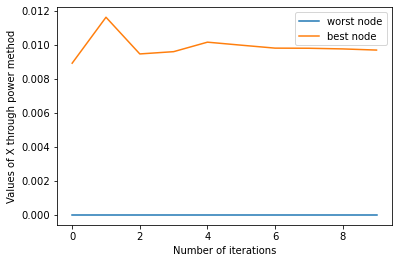

In [100]:
#Plot the values of the best and worst node through the first 10 iterations
plt.plot(Xmin[:10],label='worst node')
plt.plot(Xmax[:10],label='best node')
plt.legend()
plt.xlabel("Number of iterations")
plt.ylabel("Values of X through power method")
plt.show()

In [101]:
#Run the power method for only 2 iterations
#In the second iteration append in a list those nodes that converged
#The converge criterion was the norm of the difference in each node between the present and the previous value to be smaller than τ = 10^(−8)
X0=np.array([1/n1]*n1)
terminate=10**100
converge=[]
iteration=0
while terminate>t:
    X=alpha1*sparse.csr_matrix.dot(X0.T,P1)+(alpha1*np.dot(X0.T,a1)+(1-alpha1))*v.T
    if iteration==2:
        for i in range(n1):
            if norm(X[i]-X0[i])<t:
                converge.append(i)
    terminate=norm(X-X0,1)
    X0=X
    iteration=iteration+1

    
#Test if the 100 best and worst node have converged (if they exist in converge list)
check100best=[]
for i in sorted1[-100:]:
    if i in converge:
        check100best.append(i)
check100worst=[]
for i in sorted1[:100]:
    if i in converge:
        check100worst.append(i)
        

if len(check100best)==0:
    print('None of the best nodes converged')
elif len(check100best)==100:
    print('All of the best nodes converged')
else:
    print("Some of the best nodes converged")
if len(check100worst)==0:
    print('None of the worst nodes converged')
elif len(check100worst)==100:
    print('All of the worst nodes converged')
else:
    print("Some of the worst converged")

None of the best nodes converged
All of the worst nodes converged


In [137]:
print(check100best)
print(check100worst)

[]
[778, 779, 780, 781, 2860, 3226, 3367, 3368, 3557, 3558, 3559, 3742, 3743, 3744, 3914, 3915, 3916, 4125, 4151, 4177, 4204, 4391, 4392, 4393, 4534, 4535, 4562, 4563, 4590, 4615, 4645, 4673, 4968, 4995, 5022, 5048, 5171, 5172, 5199, 5200, 5252, 5435, 5436, 5437, 5438, 5465, 5653, 5654, 5655, 5682, 5869, 5870, 5871, 6054, 6055, 6056, 6244, 6245, 6246, 6421, 6561, 6562, 6742, 6743, 6744, 6932, 6933, 6934, 7119, 7120, 7121, 7326, 7352, 7378, 7403, 7589, 7590, 7591, 7728, 7729, 7756, 7757, 7784, 7811, 7837, 7863, 8028, 8054, 8081, 8108, 8243, 8244, 8271, 8272, 8299, 8324, 8510, 8511, 8512, 8513]


#### 4. Προσθέστε έναν δικό σας, επιπλέον, κόμβο ο οποίος να ‘δείχνει ’ στους 10 σημαντικότερους (με α = 0.85 ) κόμβους και να έχει in-links από 500 κόμβους που ήταν στην προηγούμενη αξιολόγηση κάτω από την μέση. Ξανατρέξτε τις παραπάνω μεθόδους. Σε ποια θέση αξιολογήθηκε ο νέος κόμβος;

For this task we add one extra node in the matrix P. The shape of this matrix will become (685231,685231). The row with the new node will include the probability (1/10) in the top 10 nodes (outlinks). Also, some random nodes with ranking below the middle will change their probability distributed in their rows as they will connect to the new node.

In [103]:
#Create DataFrame with the 10 best nodes
top10=sorted1[-10:]
top10=pd.DataFrame(top10)
top10=top10.rename(columns={0:'outlink'})

In [104]:
#Select a random seed
np.random.seed(seed=1111)

#Create a list with nodes that were below the middle in ranking
midbottom=sorted1[:(int((len(sorted1))/2))]

#Create a random list with 500 nodes below the middle in ranking
mid500=np.random.choice(midbottom,500,replace=False)
mid500=pd.DataFrame(mid500)
mid500=mid500.rename(columns={0:'node'})

In [105]:
#Create DataFrame with the new node that will be added 10 times (as the new node has 10 outlinks)
#The new node will take tha value 68230 as the nodes start from zero. In reality this node is 68231
newnodes1=[n1]*10
newnodes1=pd.DataFrame(newnodes1)
newnodes1=newnodes1.rename(columns={0:'node'})

In [106]:
#Concatenate the new nodes and outlinks with the ones that already exist
nodes4=pd.concat([nodes1,newnodes1])
outlink4=pd.concat([outlink1,top10])

In [107]:
#Create DataFrame with the new outlink that will be added 500 times (as the new outlink has 500 different nodes)
#The new outlink will take tha value 68230 as the outlink start from zero. In reality this outlink is 68231
newoutlink1=[n1]*500
newoutlink1=pd.DataFrame(newoutlink1)
newoutlink1=newoutlink1.rename(columns={0:'outlink'})

In [108]:
#Concatenate the new nodes and outlinks with the ones that already exist
nodes4=pd.concat([nodes4,mid500])
outlink4=pd.concat([outlink4,newoutlink1])

In [109]:
#Create the weights that the sprarse matrix P will contain

#Calculate how many times each node appears in nodes4 DataFrame
counts4 =nodes4['node'].value_counts()

#Calculate the weight of each node
nodes4['weight'] = nodes4['node'].apply(lambda x: 1/counts4[x])

In [110]:
#Construct sparse matrix P as in pageranking.pdf
P4=sparse.csr_matrix((nodes4['weight'],(nodes4['node'],outlink4['outlink'])))

In [111]:
#Number of nodes
n4=P4.shape[0]

#Create a starting vector X
X0=np.array([1/n4]*n4)

#Create v vector as in pageranking.pdf
v4=np.array([1/n4]*n4)

In [112]:
#Calculate vector a
a4=a_function(n4,P4)

In [113]:
#Calculate X vector with power method
start_time = time.time()
X4,iteration4=X_function(X0,P4,t,alpha1,a4,v4)

#Calculate the time and number of iterations of power method
print("Power method needed",time.time()-start_time,"seconds and ", iteration4, "iterations")

Power method needed 2.020200729370117 seconds and  92 iterations


In [114]:
#Rank each node based on the X
rank4=rankdata(([-1 * i for i in X4]),method='ordinal') 

#Sort the ranked nodes
sorted4=np.argsort(rank4)

### *** Note 3:
#### Rankdata which is used above, ranks each node from best to worst, as it assigns the rank 1 to the node with the highest value in vector π and the rank 685231 to the worst node.
#### Sorted4 vector sorts the nodes from the best to the worst node. (Due to convenience nodes start from zero to 685230. Hence, the nodes in reality need the addition of 1)

In [115]:
print('The ranking of the new node that was added is',rank4[-1])

The ranking of the new node that was added is 4122


#### 5. Στο προηγούμενο ερώτημα αντιστρέψτε τα in-links με τα out-links. Συγκεκριμένα, βάλτε οι 10 σημαντικότεροι κόμβοι να ‘δείχνουν’ τη σελίδα σας και αυτή να δείχνει στους 10 πιο ασήμαντους. Ποια είναι τώρα η νέα ιεραρχική θέση του κόμβου σας αλλά και πως μεταβλήθηκε η θέση των 10 σημαντικών και ασήμαντων κόμβων ;

### Note: 
#### This task asks to reverse what was aksed in the previous task, however afterwards it asks to add the 10 most important nodes as outlinks to the new node and add to the 10 least important nodes the new node as outlink.
#### It is not clear if it needed to just reverse the inlinks-outlinks from the previous task

For this task we add one extra node in the matrix P. The shape of this matrix will become (685231,685231). The row with the new node will include the probability (1/10) in the bottom 10 nodes (outlinks). Also, some random nodes with the top 10 ranking will change their probability distributed in their rows as they will connect to the new node.

In [116]:
#Create DataFrame with the 10 worst nodes
bottom10=sorted1[:10]
bottom10=pd.DataFrame(bottom10)
bottom10=bottom10.rename(columns={0:'outlink'})

In [117]:
#Create DataFrame with the new node that will be added 10 times (as the new node has 10 outlinks)
#The new node will take tha value 68230 as the nodes start from zero. In reality this node is 68231
newnodes2=[n4-1]*10
newnodes2=pd.DataFrame(newnodes2)
newnodes2=newnodes2.rename(columns={0:'node'})

In [118]:
#Concatenate the new nodes and outlinks with the ones that already exist
nodes5=pd.concat([nodes1,newnodes2])
outlink5=pd.concat([outlink1,bottom10])

In [119]:
#Create DataFrame with the new outlink that will be added 10 times (as the new outlink has 10 different nodes)
#The new outlink will take tha value 68230 as the outlink start from zero. In reality this outlink is 68231
newoutlink2=[n4-1]*10
newoutlink2=pd.DataFrame(newoutlink2)
newoutlink2=newoutlink2.rename(columns={0:'outlink'})

In [120]:
#Rename top10 list column from outlink to node for this assignment task
top10=top10.rename(columns={'outlink':'node'})

In [121]:
#Concatenate the new nodes and outlinks with the ones that already exist
nodes5=pd.concat([nodes5,top10])
outlink5=pd.concat([outlink5,newoutlink2])

In [122]:
#Create the weights that the sprarse matrix P will contain

#Calculate how many times each node appears in nodes5 DataFrame
counts5 =nodes5['node'].value_counts()

#Calculate the weight of each node
nodes5['weight'] = nodes5['node'].apply(lambda x: 1/counts5[x])

In [123]:
#Construct sparse matrix P as in pageranking.pdf
P5=sparse.csr_matrix((nodes5['weight'],(nodes5['node'],outlink5['outlink'])))

In [124]:
#Number of nodes
n5=P5.shape[0]

#Create a starting vector X
X0=np.array([1/n5]*n5)

#Create v vector as in pageranking.pdf
v5=np.array([1/n5]*n5)

In [125]:
#Calculate vector a
a5=a_function(n5,P5)

In [126]:
#Calculate X vector with power method
start_time = time.time()
X5,iteration5=X_function(X0,P5,t,alpha1,a5,v5)

#Calculate the time and number of iterations of power method
print("Power method needed",time.time()-start_time,"seconds and ", iteration5, "iterations")

Power method needed 2.1278555393218994 seconds and  92 iterations


In [127]:
#Rank each node based on the X
rank5=rankdata(([-1 * i for i in X5]),method='ordinal')  

#Sort the ranked nodes
sorted5=np.argsort(rank5)

### *** Note 3:
#### Rankdata which is used above, ranks each node from best to worst, as it assigns the rank 1 to the node with the highest value in vector π and the rank 685230 to the worst node.
#### Sorted4 vector sorts the nodes from the best to the worst node. (Due to convenience nodes start from zero to 685229. Hence, the nodes in reality need the addition of 1)

In [128]:
print('The ranking of the new node that was added is',rank5[-1])

The ranking of the new node that was added is 12


In [138]:
print('The best nodes in task 4')
print(sorted4[:10]+1)
print('The best nodes in task 5')
print(sorted5[:10]+1)

The best nodes in task 4
[288239     10 225466  54131   1284 564115 288347  65123    114    115]
The best nodes in task 5
[288239     10 225466  54131   1284 564115    114    115 288347  65123]


In [139]:
print('The worst nodes in task 4')
print(sorted4[-10:]+1)
print('The worst nodes in task 5')
print(sorted5[-10:]+1)

The worst nodes in task 4
[685175 685176 685177 685178 685179 685180 685185 685218 685227 685228]
The worst nodes in task 5
[685175 685176 685177 685178 685179 685180 685185 685218 685227 685228]


We observe that the 10 worst nodes in task 4 and task 5 remain the same as the addition of the new node do not affect the other nodes much. The 10 best nodes remain the same with the exception of two nodes that changed ranking with two others but all of them remained in the top 10 ranking.